# Dynamic WSCC 9-bus System with Switch

In [10]:
import villas.dataprocessing.plottools as pt
import villas.dataprocessing.readtools as rt
from villas.dataprocessing.timeseries import TimeSeries as ts
import matplotlib.pyplot as plt
import re
import dpsimpy
import glob
import os
import numpy as np

# %matplotlib widget

In [11]:
top_path = os.popen('git rev-parse --show-toplevel').read().strip()
files = glob.glob(top_path + '/build/_deps/cim-data-src/WSCC-09/WSCC-09_RX_Dyn/*.xml')
print(files)

sim_name = 'DP_WSCC-9bus_dyn_switch'

['/dpsim/build/_deps/cim-data-src/WSCC-09/WSCC-09_RX_Dyn/WSCC-09_RX_SV.xml', '/dpsim/build/_deps/cim-data-src/WSCC-09/WSCC-09_RX_Dyn/WSCC-09_RX_EQ.xml', '/dpsim/build/_deps/cim-data-src/WSCC-09/WSCC-09_RX_Dyn/WSCC-09_RX_DI.xml', '/dpsim/build/_deps/cim-data-src/WSCC-09/WSCC-09_RX_Dyn/WSCC-09_RX_TP.xml']


In [12]:
dpsimpy.Logger.set_log_dir('logs/' + sim_name)
reader = dpsimpy.CIMReader(sim_name, dpsimpy.LogLevel.debug, dpsimpy.LogLevel.debug)
system = reader.loadCIM(60, files, dpsimpy.Domain.DP, dpsimpy.PhaseType.Single, dpsimpy.GeneratorType.TransientStability)

CIMContentHandler: Note: 0 out of 492 tasks remain unresolved!


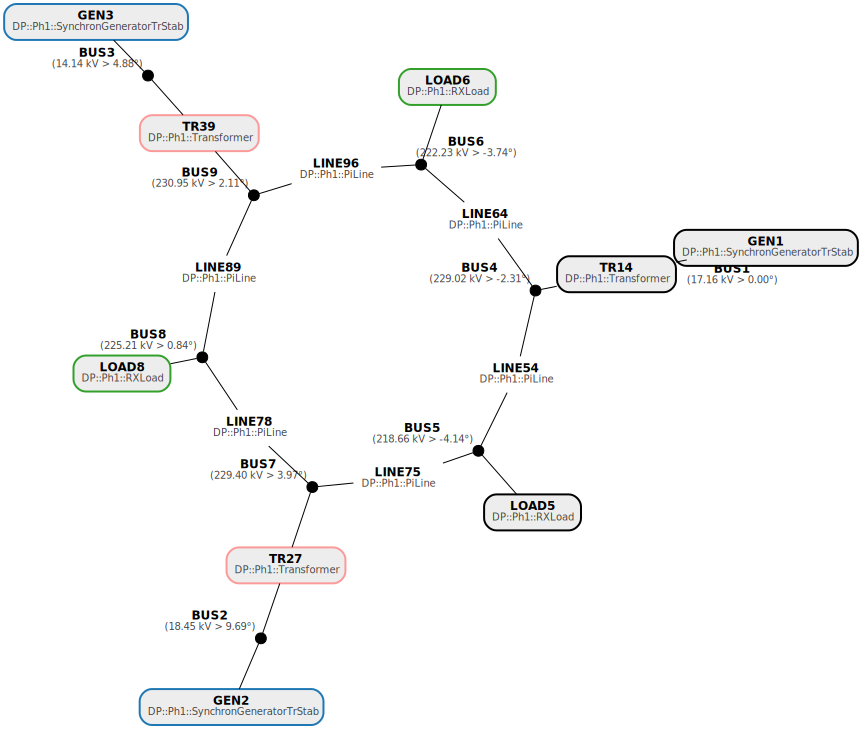

In [13]:
system

In [14]:
sw = dpsimpy.dp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
sw.set_parameters(1e12, 0.1*529)
sw.connect([dpsimpy.dp.SimNode.gnd, system.node('BUS7')])
sw.open()
system.add(sw)

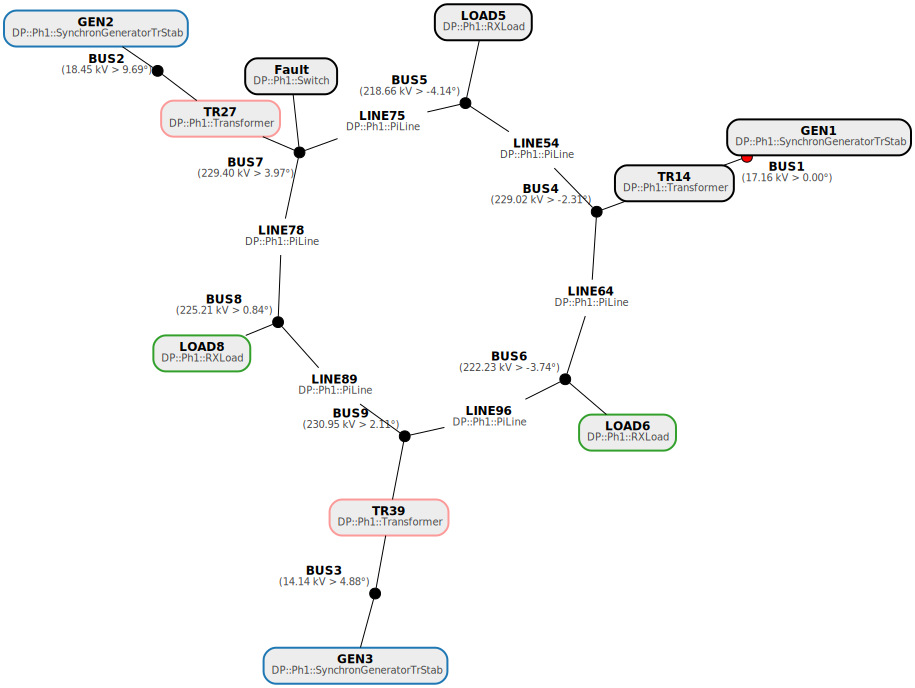

In [15]:
system

## Simulation

In [5]:
# Extend topology with switch
sw = dpsimpy.dp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
sw.set_parameters(1e12, 0.1*529)
sw.connect([dpsimpy.dp.SimNode.gnd, system.node('BUS7')])
sw.open()
system.add(sw)

# Use omegNom for torque conversion in SG models for validation with PSAT
system.component('GEN1').set_model_flags(False, False)
system.component('GEN2').set_model_flags(False, False)
system.component('GEN3').set_model_flags(False, False)

logger = dpsimpy.Logger(sim_name)

for i in range(1, 10):
    logger.log_attribute('v' + str(i), 'v', system.node('BUS' + str(i)))

for i in range(1, 4):
    logger.log_attribute('wr_' + str(i), 'w_r', system.component('GEN' + str(i)))
    logger.log_attribute('delta_r_' + str(i), 'delta_r', system.component('GEN' + str(i)))
    logger.log_attribute('P_elec_' + str(i), 'P_elec', system.component('GEN' + str(i)))
    logger.log_attribute('P_mech_' + str(i), 'P_mech', system.component('GEN' + str(i)))


sim = dpsimpy.Simulation(sim_name, dpsimpy.LogLevel.debug)
sim.set_system(system)
sim.set_time_step(0.0001)
sim.set_final_time(2.0)
sim.set_domain(dpsimpy.Domain.DP)
sim.set_solver(dpsimpy.Solver.MNA)
sim.do_init_from_nodes_and_terminals(True)

sw_event_1 = dpsimpy.event.SwitchEvent(0.2 - 0.0001, sw, True)
sim.add_event(sw_event_1)

sim.add_logger(logger)
sim.run()


1.999000e-01: Handle event time


[06:40:33.330801 DP_WSCC-9bus_dyn_switch info] Initialize simulation: DP_WSCC-9bus_dyn_switch
[06:40:33.331129 MnaSolverFactory info] creating EigenDense solver implementation
[06:40:33.408593 DP_WSCC-9bus_dyn_switch info] Scheduling tasks.
[06:40:33.409802 DP_WSCC-9bus_dyn_switch info] Scheduling done.
[06:40:33.409806 DP_WSCC-9bus_dyn_switch info] Opening interfaces.
[06:40:33.409809 DP_WSCC-9bus_dyn_switch info] Start synchronization with remotes on 0 interfaces
[06:40:33.409810 DP_WSCC-9bus_dyn_switch info] Synchronized simulation start with remotes
[06:40:33.409811 DP_WSCC-9bus_dyn_switch info] Start simulation: DP_WSCC-9bus_dyn_switch
[06:40:33.409814 DP_WSCC-9bus_dyn_switch info] Time step: 1.000000e-04
[06:40:33.409816 DP_WSCC-9bus_dyn_switch info] Final time: 2.000000e+00
[06:40:39.703998 DP_WSCC-9bus_dyn_switch info] Simulation calculation time: 6.294173
[06:40:39.704380 DP_WSCC-9bus_dyn_switch info] Simulation finished.


## Read simulation results

In [6]:
path = 'logs/SP_WSCC-9bus_dyn_switch/'
logName = 'SP_WSCC-9bus_dyn_switch'
logFilename = path + logName + '.csv'
print(logFilename)

ts_dpsim = rt.read_timeseries_dpsim(logFilename)
phasors = ts.phasors(ts_dpsim)

logs/SP_WSCC-9bus_dyn_switch/SP_WSCC-9bus_dyn_switch.csv
column number: 21
results length: 20001
real column names: ['P_elec_1', 'P_elec_2', 'P_elec_3', 'P_mech_1', 'P_mech_2', 'P_mech_3', 'delta_r_1', 'delta_r_2', 'delta_r_3', 'wr_1', 'wr_2', 'wr_3']
complex column names: ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']


### Phasors at last time step in per unit

In [7]:
nominal_voltages = {'v1': 16500, 'v2': 18000, 'v3': 13800, 
                         'v4': 230000, 'v5': 230000, 'v6': 230000, 
                         'v7': 230000, 'v8': 230000, 'v9': 230000} 
for node, nom_voltage in nominal_voltages.items():
    print(node + ': ' + str(phasors[node]['abs'].values[0] / nom_voltage) + '<' + str(phasors[node]['phase'].values[0]))

v1: 1.0362421398567414<-0.05799403104286403
v2: 1.0192801128443203<9.617668409208997
v3: 1.0175544748515057<4.778146483547308
v4: 0.9912802566532171<-2.344963993370076
v5: 0.9494397053524667<-4.151119767554759
v6: 0.9644921974064726<-3.754017155074152
v7: 0.9916104693755445<3.9165090514568113
v8: 0.9769009226343793<0.8136843407377073
v9: 0.9968573829603433<2.0325320534303324


### Plot node voltages

(0.0, 240000.0)

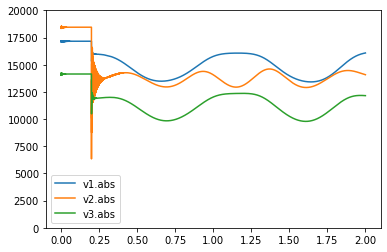

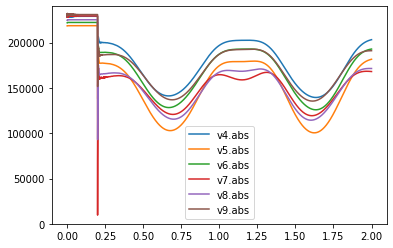

In [8]:
plt.figure()
plt.plot(phasors['v1']['abs'].time, phasors['v1']['abs'].values, label='v1.abs')
plt.plot(phasors['v2']['abs'].time, phasors['v2']['abs'].values, label='v2.abs')
plt.plot(phasors['v3']['abs'].time, phasors['v3']['abs'].values, label='v3.abs')
plt.legend()
plt.ylim([0,20000])

plt.figure()
plt.plot(phasors['v4']['abs'].time, phasors['v4']['abs'].values, label='v4.abs')
plt.plot(phasors['v5']['abs'].time, phasors['v5']['abs'].values, label='v5.abs')
plt.plot(phasors['v6']['abs'].time, phasors['v6']['abs'].values, label='v6.abs')
plt.plot(phasors['v7']['abs'].time, phasors['v7']['abs'].values, label='v7.abs')
plt.plot(phasors['v8']['abs'].time, phasors['v8']['abs'].values, label='v8.abs')
plt.plot(phasors['v9']['abs'].time, phasors['v9']['abs'].values, label='v9.abs')
plt.legend()
plt.ylim([0,240000])

### Generator Speed

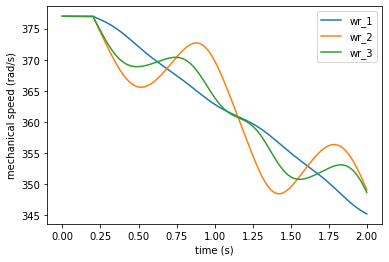

In [9]:
plt.figure()
plt.plot(ts_dpsim['wr_1'].time, ts_dpsim['wr_1'].values, label='wr_1')
plt.plot(ts_dpsim['wr_2'].time, ts_dpsim['wr_2'].values, label='wr_2')
plt.plot(ts_dpsim['wr_3'].time, ts_dpsim['wr_3'].values, label='wr_3')
plt.xlabel('time (s)')
plt.ylabel('mechanical speed (rad/s)')
plt.legend()
#plt.savefig('wscc_9bus_fault_gen_speed.pdf')

## Validation with PSAT

In [22]:
import os
import urllib.request

if not os.path.exists('reference-results'):
    os.mkdir('reference-results')

url = 'https://git.rwth-aachen.de/acs/public/simulation/reference-results/raw/master/PSAT/WSCC-9bus/d_009_fault_dpsim_01.out'
local_file = 'reference-results/d_009_fault_dpsim_01.out'
urllib.request.urlretrieve(url, local_file) 

syngen_power_name_dpsim_list = ['P_elec_1', 'P_elec_2', 'P_elec_3']
syngen_power_name_psat_list = ['p_Syn_1', 'p_Syn_2', 'p_Syn_3']

syngen_omega_name_dpsim_list = ['wr_1', 'wr_2', 'wr_3']
syngen_omega_name_psat_list = ['omega_Syn_1', 'omega_Syn_2', 'omega_Syn_3']

syngen_delta_name_dpsim_list = ['delta_r_1', 'delta_r_2', 'delta_r_3']
syngen_delta_name_psat_list = ['delta_Syn_1', 'delta_Syn_2', 'delta_Syn_3']

bus_volt_name_dpsim_list = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']
bus_volt_name_psat_list = ['V_Bus 1', 'V_Bus 2', 'V_Bus 3', 'V_Bus 4', 'V_Bus 5', 'V_Bus 6', 'V_Bus 7', 'V_Bus 8', 'V_Bus 9']
bus_angle_name_psat_list = ['theta_Bus 1', 'theta_Bus 2', 'theta_Bus 3', 'theta_Bus 4', 'theta_Bus 5', 'theta_Bus 6', 'theta_Bus 7', 'theta_Bus 8', 'theta_Bus 9']

timeseries_names_psat = syngen_power_name_psat_list+syngen_omega_name_psat_list+syngen_delta_name_psat_list+bus_volt_name_psat_list+bus_angle_name_psat_list

ts_psat = rt.read_timeseries_PSAT(local_file, timeseries_names_psat)

column number: 27
results length: 108
timeseries names: dict_keys(['p_Syn_1', 'p_Syn_2', 'p_Syn_3', 'omega_Syn_1', 'omega_Syn_2', 'omega_Syn_3', 'delta_Syn_1', 'delta_Syn_2', 'delta_Syn_3', 'V_Bus 1', 'V_Bus 2', 'V_Bus 3', 'V_Bus 4', 'V_Bus 5', 'V_Bus 6', 'V_Bus 7', 'V_Bus 8', 'V_Bus 9', 'theta_Bus 1', 'theta_Bus 2', 'theta_Bus 3', 'theta_Bus 4', 'theta_Bus 5', 'theta_Bus 6', 'theta_Bus 7', 'theta_Bus 8', 'theta_Bus 9'])


## Rotor speeds

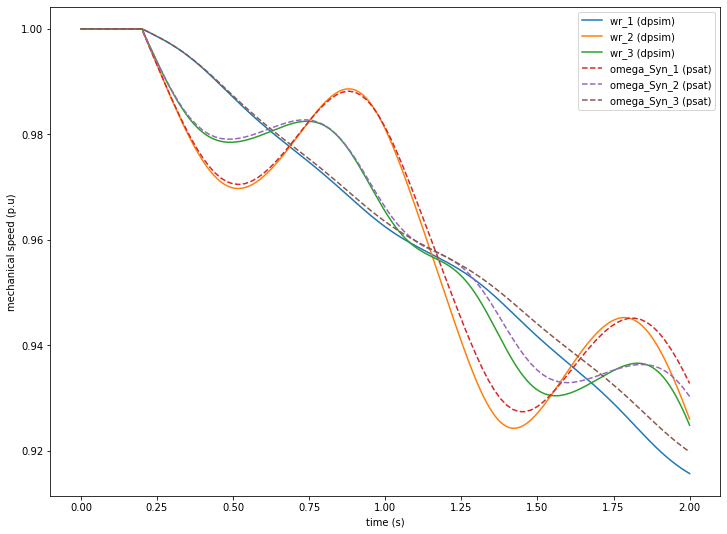

In [23]:
plt.figure(figsize=(12,9))
for syngen_omega_name_dpsim in syngen_omega_name_dpsim_list:
    ts_dpsim[syngen_omega_name_dpsim].values = ts_dpsim[syngen_omega_name_dpsim].values/(2*np.pi*60)
    plt.plot(ts_dpsim[syngen_omega_name_dpsim].time, ts_dpsim[syngen_omega_name_dpsim].values, label=syngen_omega_name_dpsim+' (dpsim)')
for syngen_omega_name_psat in syngen_omega_name_psat_list:
    plt.plot(ts_psat[syngen_omega_name_psat].time, ts_psat[syngen_omega_name_psat].values, label=syngen_omega_name_psat+' (psat)', linestyle='--')
plt.xlabel('time (s)')
plt.ylabel('mechanical speed (p.u)')
plt.legend()

## Assert rotor speeds

In [ ]:
assert(ts_dpsim[syngen_omega_name_dpsim_list[0]].rmse(ts_dpsim[syngen_omega_name_dpsim_list[0]], ts_psat[syngen_omega_name_psat_list[2]]) < 2e-4)
assert(ts_dpsim[syngen_omega_name_dpsim_list[1]].rmse(ts_dpsim[syngen_omega_name_dpsim_list[1]], ts_psat[syngen_omega_name_psat_list[0]]) < 2e-4)
assert(ts_dpsim[syngen_omega_name_dpsim_list[2]].rmse(ts_dpsim[syngen_omega_name_dpsim_list[2]], ts_psat[syngen_omega_name_psat_list[1]]) < 2e-4)

## Rotor angles

In [ ]:
plt.figure(figsize=(12,9))
for syngen_delta_name_dpsim in syngen_delta_name_dpsim_list:
    plt.plot(ts_dpsim[syngen_delta_name_dpsim].time, ts_dpsim[syngen_delta_name_dpsim].values, label=syngen_delta_name_dpsim+' (dpsim)')
for syngen_delta_name_psat in syngen_delta_name_psat_list:
    plt.plot(ts_psat[syngen_delta_name_psat].time, ts_psat[syngen_delta_name_psat].values, label=syngen_delta_name_psat+' (psat)', linestyle='--')
plt.xlabel('time (s)')
plt.ylabel('rotor angle (deg)')
plt.legend()

## Bus voltages

In [ ]:
plt.figure(figsize=(12,9))
for bus_volt_name_dpsim in bus_volt_name_dpsim_list:
    if bus_volt_name_dpsim == 'v1':
        plt.plot(ts_dpsim[bus_volt_name_dpsim].time, ts_dpsim[bus_volt_name_dpsim].abs().values/16.5e3, label=bus_volt_name_dpsim + ' (dpsim)', color='C'+str(bus_volt_name_dpsim_list.index(bus_volt_name_dpsim)))
    elif bus_volt_name_dpsim == 'v2':
        plt.plot(ts_dpsim[bus_volt_name_dpsim].time, ts_dpsim[bus_volt_name_dpsim].abs().values/18e3, label=bus_volt_name_dpsim + ' (dpsim)', color='C'+str(bus_volt_name_dpsim_list.index(bus_volt_name_dpsim)))
    elif bus_volt_name_dpsim == 'v3':
        plt.plot(ts_dpsim[bus_volt_name_dpsim].time, ts_dpsim[bus_volt_name_dpsim].abs().values/13.8e3, label=bus_volt_name_dpsim + ' (dpsim)', color='C'+str(bus_volt_name_dpsim_list.index(bus_volt_name_dpsim)))
    else:
        plt.plot(ts_dpsim[bus_volt_name_dpsim].time, ts_dpsim[bus_volt_name_dpsim].abs().values/230e3, label=bus_volt_name_dpsim + ' (dpsim)', color='C'+str(bus_volt_name_dpsim_list.index(bus_volt_name_dpsim)))
for bus_volt_name_psat in bus_volt_name_psat_list:
        plt.plot(ts_psat[bus_volt_name_psat].time, ts_psat[bus_volt_name_psat].values, label=bus_volt_name_psat + ' (psat)', linestyle='--', color='C'+str(bus_volt_name_psat_list.index(bus_volt_name_psat)))
plt.xlabel('time (s)')
plt.ylabel('voltage (p.u.)')
plt.legend()

## Bus angles

In [ ]:
plt.figure(figsize=(12,9))
for bus_volt_name_dpsim in bus_volt_name_dpsim_list:
    plt.plot(ts_dpsim[bus_volt_name_dpsim].time, ts_dpsim[bus_volt_name_dpsim].phase().values/180*np.pi, label=bus_volt_name_dpsim + ' (dpsim)', color='C'+str(bus_volt_name_dpsim_list.index(bus_volt_name_dpsim)))
for bus_angle_name_psat in bus_angle_name_psat_list:
    plt.plot(ts_psat[bus_angle_name_psat].time, ts_psat[bus_angle_name_psat].values, label=bus_angle_name_psat + ' (psat)', linestyle='--', color='C'+str(bus_angle_name_psat_list.index(bus_angle_name_psat)))
plt.xlabel('time (s)')
plt.ylabel('angle (rad)')
plt.legend()

## SG active power

In [ ]:
plt.figure(figsize=(12,9))
for syngen_power_name_dpsim in syngen_power_name_dpsim_list:
    plt.plot(ts_dpsim[syngen_power_name_dpsim].time, ts_dpsim[syngen_power_name_dpsim].values/100e6, label=syngen_power_name_dpsim+' (dpsim)')
for syngen_power_name_psat in syngen_power_name_psat_list:
    plt.plot(ts_psat[syngen_power_name_psat].time, ts_psat[syngen_power_name_psat].values, label=syngen_power_name_psat+' (psat)', linestyle='--')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()